In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

In [3]:
import sys
sys.path.append('../experiments/')
from train_test import make_parser, generate_data

_data = {}

def get_data(sz, prop_min):
    if (sz, prop_min) in _data:
        return _data[sz, prop_min]
    
    parser = make_parser()
    args = ['chi2', '--type=fourier', 'out']
    if sz == 'big':
        args += ['--data-seed=23']
    elif sz == 'small':
        args += ['--data-seed=47', '--n-train=150']
    else:
        raise ValueError()
    args += ['--min-size', str(prop_min), '--max-size', str(50 - prop_min),
             '--size-type', 'manual']
    
    args = parser.parse_args(args)
    train, estop, val, test = _data[sz, prop_min] = generate_data(args)
    return train, estop, val, test

ImportError: No module named bdr

In [5]:
from glob import glob
import os
import re

In [6]:
data = []

# pat = re.compile('(big|small)/(.*)/(.*)\.npz')
pat = re.compile('(big)/(.*)/(.*)\.npz')
for fn in glob('big/*/*.npz'):
    sz, method, prop_small = pat.match(fn).groups()
    prop_small = int(prop_small)
    
    train, estop, val, test = get_data(sz, prop_small)
    
    with np.load(fn) as d:
        assert np.allclose(test.y, d['test_y'])
        means = d['test_preds']
        if method == 'optimal_23':
            stds = np.sqrt(d['test_pred_vars'])
            nll = d['test_pred_nlls']
        elif 'test_preds_var' in d:
            stds = np.sqrt(d['test_preds_var'])
            nll = -stats.norm.logpdf(test.y, means, stds)
        else:
            stds = nll = np.nan
        data.append(pd.DataFrame.from_dict(dict(
            ds_size=sz,
            prop_small=prop_small,
            method=method,
            pt_idx=np.arange(len(test)),
            y=test.y,
            pred=means,
            pred_std=stds,
            pred_nll=nll,
            n_pts=test.n_pts,
        )))

# pat = re.compile('(big|small)/(.*)/.*-(\d+)-j_\d+\.csv')
pat = re.compile('(big)/(.*)/.*-d:chi2-manual-(\d+)-.*\.csv')
for fn in glob('big/*/results-*.csv'):
    sz, method, prop_small = pat.match(fn).groups()
    prop_small = int(prop_small)
    train, estop, val, test = get_data(sz, prop_small)
    
    d = pd.read_csv(fn)
    assert len(d) == len(train) + len(val) + len(test)
    d = d[-len(test):]
    d.rename(columns={'mu': 'pred', 'sd': 'pred_std', 'lp': 'pred_nll'}, inplace=True)
    d.pred_nll *= -1
    d['ds_size'] = sz
    d['prop_small'] = prop_small
    d['method'] = method
    d['pt_idx'] = np.arange(len(test))
    d['n_pts'] = test.n_pts
    data.append(d)
        
data = pd.concat(data).set_index(['ds_size', 'prop_small', 'method', 'pt_idx']).sort_index()

NameError: name 'get_data' is not defined

In [6]:
data['sqerr'] = (data.y - data.pred) ** 2

In [7]:
data.xs(0, level='pt_idx').xs(0, level='prop_small')

n_pts      pred  pred_nll  pred_std         y  \
ds_size method                                                                
big     bdr                    1000  6.320501 -0.525509  0.171555  6.466683   
        bdr_real_r             1000  6.397922 -0.381842  0.260679  6.466683   
        blr                    1000  6.220544  0.243670  0.433116  6.466683   
        optimal_23             1000  6.278023  0.049314  0.119467  6.466683   
        radial                 1000  6.262313       NaN       NaN  6.466683   
        radialblr              1000  6.220544  0.243670  0.433116  6.466683   
        shrinkage              1000  6.383545 -0.498170  0.226640  6.466683   
        shrinkage_rbf_1.0      1000  6.266285 -0.134205  0.161427  6.466683   
        shrinkage_rbf_real_r   1000  6.336123 -0.564717  0.167216  6.466683   

                                 sqerr  
ds_size method                          
big     bdr                   0.021369  
        bdr_real_r            0.004728  
        blr                   0.060584  
        optimal_23            0.035593  
        radial                0.041767  
        radialblr             0.060584  
        shrinkage             0.006912  
        shrinkage_rbf_1.0     0.040159  
        shrinkage_rbf_real_r  0.017046

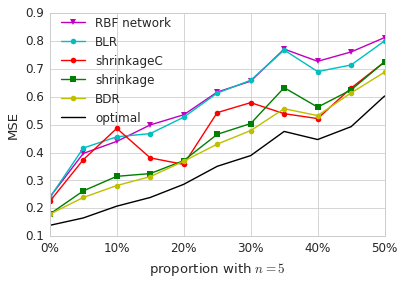

In [44]:
for sz in ['big']: #, 'small']:
    plt.figure()
    props = data.index.get_level_values('prop_small').unique()
#     plt.plot(props, [get_data(sz, p)[-1].y.var() for p in props], color='k', ls='--', lw=1,
#              label='mean label')

    g = lambda m: data.sqerr.loc[sz].xs(m, level='method').groupby(level=0).mean()

    g('radial').plot(color='m', marker='v', label='RBF network')
    g('radialblr').plot(color='c', marker='o', label='BLR')
    if sz == 'big':
        g('shrinkage_rbf_real_r').plot(color='r', marker='o', label='shrinkageC')
    g('shrinkage_rbf_1.0').plot(color='g', marker='s', label='shrinkage')
    g('bdr').plot(color='y', marker= 'o', label='BDR')
    g('optimal_23').plot(color='k', label='optimal')

    plt.legend(loc=(.02, .48))
    plt.ylabel('MSE')
    plt.xlabel('proportion with $n=5$')
    from matplotlib.ticker import FuncFormatter
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.0%}'.format(x / 100.)))
    
#     plt.title(sz)
    plt.savefig('../drafts/ai_stats/figs/mse_{}.pdf'.format(sz), bbox_inches='tight', pad_inches=0)

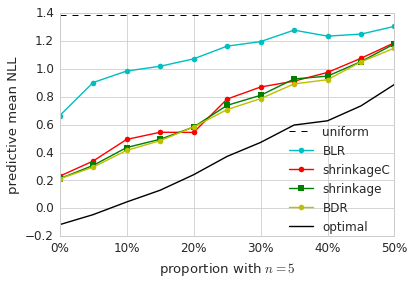

In [29]:
for sz in ['big']: #, 'small']:
    plt.figure()
    props = data.index.get_level_values('prop_small').unique()
    unifs = np.empty(props.shape)
    for i, p in enumerate(props):
        _, _, _, test = get_data(sz, p)
        unifs[i] = np.log(test.y.max() - test.y.min())
    plt.plot(props, unifs, color='k', ls='--', lw=1, label='uniform')

    g = lambda m: data.pred_nll.loc[sz].xs(m, level='method').groupby(level=0).mean()

    g('radialblr').plot(color='c', marker='o', label='BLR')
    if sz == 'big':
        g('shrinkage_rbf_real_r').plot(color='r', marker='o', label='shrinkageC')
    g('shrinkage_rbf_1.0').plot(color='g', marker='s', label='shrinkage')
    g('bdr').plot(color='y', marker='o', label='BDR')
    g('optimal_23').plot(color='k', label='optimal')

    plt.legend(loc=(.67, -.01))
    plt.ylabel('predictive mean NLL')
    plt.xlabel('proportion with $n=5$')
    from matplotlib.ticker import FuncFormatter
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.0%}'.format(x / 100.)))
    
    plt.savefig('../drafts/ai_stats/figs/nll_{}.pdf'.format(sz), bbox_inches='tight', pad_inches=0)

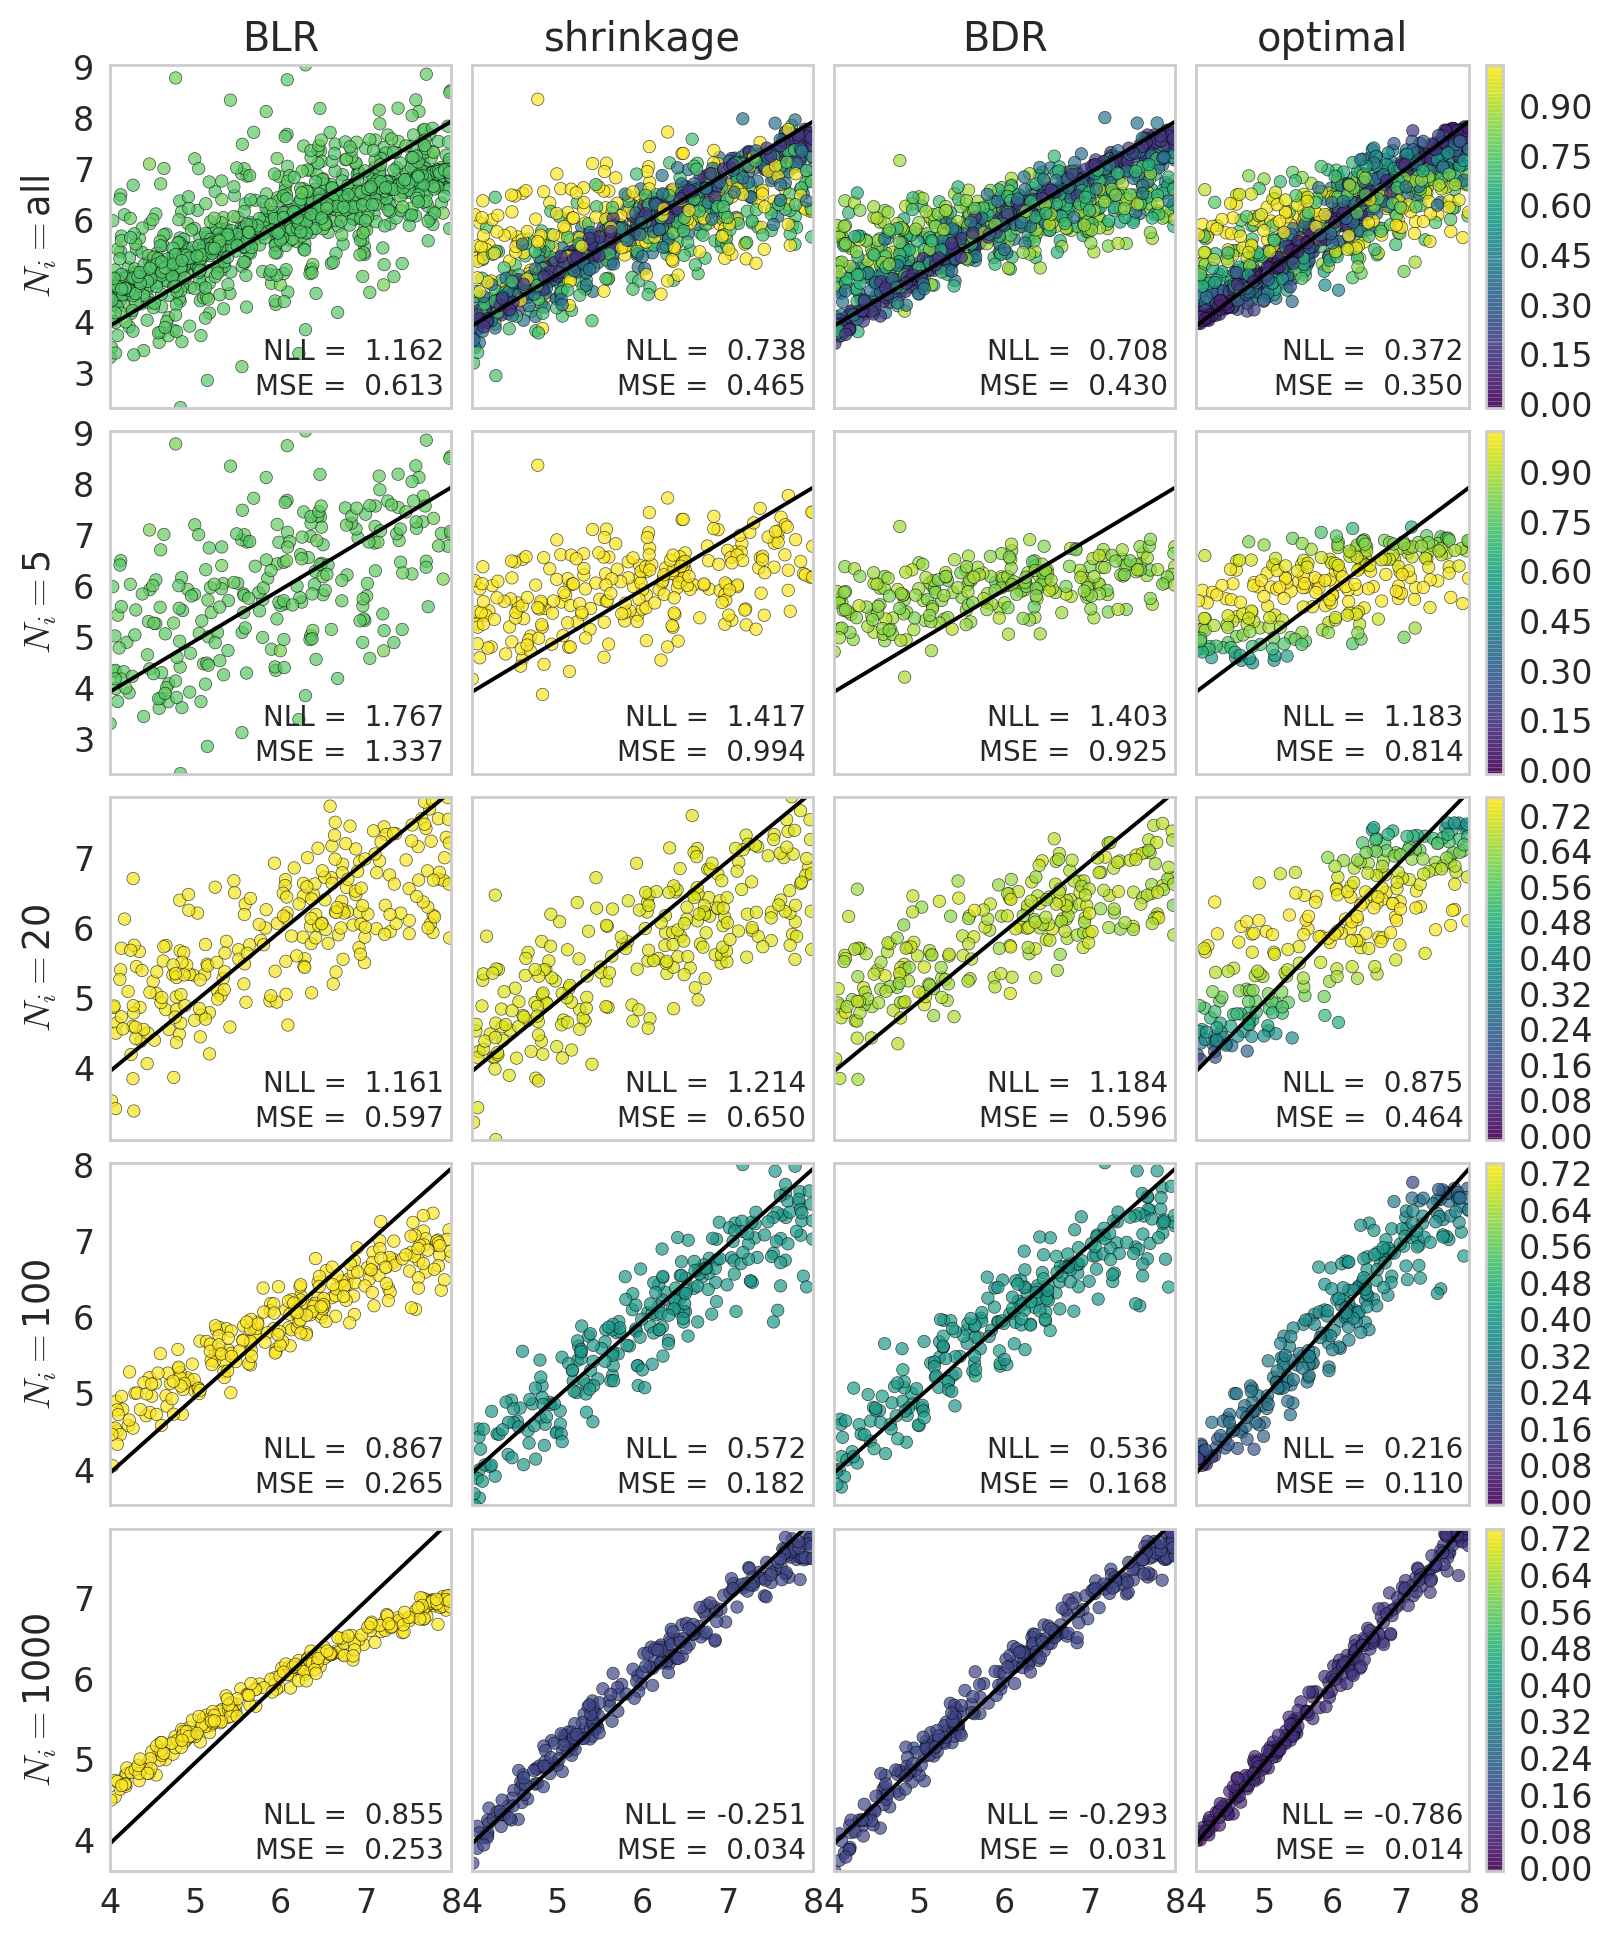

In [43]:
from matplotlib.ticker import MultipleLocator

sizes = np.r_[np.nan, np.sort(data.n_pts.unique())]

method_names = np.array(['BLR', 'shrinkage', 'BDR', 'optimal'])
methods = np.array(['radialblr', 'shrinkage_rbf_1.0', 'bdr', 'optimal_23'])

sub = data.loc['big', 25].loc[list(methods)]

plt.figure(figsize=(7.9, 9.5), dpi=200)

for i, s in enumerate(sizes):
    sub_size = sub if np.isnan(s) else sub[sub.n_pts == s]
    
    std_max = sub_size.pred_std.max()
    ylo = sub_size.pred.min()
    yhi = sub_size.pred.max()
    
    for j, (m, m_name) in enumerate(zip(methods, method_names)):
        bit = sub_size.loc[m]
        ax = plt.subplot(sizes.size, methods.size, i * methods.size + j + 1)
        
        if i == 0:
            plt.title(m_name)
        if j == 0:
            plt.ylabel(r'$N_i = ${}'.format('all' if i == 0 else int(s)))
            
        plt.plot([4, 8], [4, 8], color='k')
        plt.scatter(bit.y, bit.pred, c=bit.pred_std, cmap='viridis', vmin=0, vmax=std_max,
                   alpha=.7)
        
        plt.grid(False)
        if i != sizes.size - 1:
            plt.xticks([], [])
        else:
            ax.xaxis.set_major_locator(MultipleLocator(1))
        if j != 0:
            plt.yticks([], [])
        else:
            ax.yaxis.set_major_locator(MultipleLocator(1))

        if j == methods.size - 1:
            cbar = plt.colorbar()
#             cbar.ax.yaxis.set_major_locator(MultipleLocator(.1))
        
        plt.xlim(4, 8)
        plt.ylim(ylo, yhi)
        
        plt.annotate('MSE = {: .3f}'.format(bit.sqerr.mean()),
                     xy=(.98, 0.02), xycoords='axes fraction', ha='right', va='bottom',
                     fontsize=10)
        plt.annotate('NLL = {: .3f}'.format(bit.pred_nll.mean()),
                     xy=(.98, 0.12), xycoords='axes fraction', ha='right', va='bottom',
                     fontsize=10)
plt.tight_layout(pad=0)
plt.savefig('../drafts/ai_stats/figs/preds.pdf', bbox_inches='tight', pad_inches=0)